In [92]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, LSTM, Dense, BatchNormalization, Dropout
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import os
import datetime
import numpy as np

from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.model_selection import KFold
from keras.wrappers.scikit_learn import KerasClassifier

In [93]:
df = pd.read_csv('./Data/BTC-USDT_Data/BTC-USDT_Data_1m/BTC_USDT_1m_All.csv')
df

,Open_time,Open,High,Low,Close,Volume,quote_av,trades,tb_base_av,tb_quote_av,Symbol
0,2017-08-17 13:00:00,4261.48,4261.48,4261.48,4261.48,1.775183,7.564907e+03,3,0.075183,3.203909e+02,BTCUSDT
1,2017-08-17 13:01:00,4261.48,4261.48,4261.48,4261.48,0.000000,0.000000e+00,0,0.000000,0.000000e+00,BTCUSDT
2,2017-08-17 13:02:00,4280.56,4280.56,4280.56,4280.56,0.261074,1.117543e+03,2,0.261074,1.117543e+03,BTCUSDT
3,2017-08-17 13:03:00,4261.48,4261.48,4261.48,4261.48,0.012008,5.117185e+01,3,0.012008,5.117185e+01,BTCUSDT
4,2017-08-17 13:04:00,4261.48,4261.48,4261.48,4261.48,0.140796,5.999993e+02,1,0.140796,5.999993e+02,BTCUSDT
...,...,...,...,...,...,...,...,...,...,...,...
2817383,2022-12-31 23:55:00,16582.94,16596.00,16582.82,16594.89,201.694600,3.345834e+06,3245,125.003820,2.073599e+06,BTCUSDT
2817384,2022-12-31 23:56:00,16594.89,16598.00,16589.41,16595.37,137.153070,2.275849e+06,3124,66.610050,1.105296e+06,BTCUSDT
2817385,2022-12-31 23:57:00,16595.37,16596.45,16591.73,16595.07,62.508600,1.037282e+06,2086,31.996350,5.309577e+05,BTCUSDT
2817386,2022-12-31 23:58:00,16594.39,16595.08,16592.24,16593.67,44.594320,7.399709e+05,1529,23.273400,3.861846e+05,BTCUSDT


In [94]:
df['Return'] = df['Close'].pct_change() # Return 계산
df['Maximum Hour Return'] = df['Return'].rolling(window=60).max() # Calculate maximum return
df['Price Volatility'] = df['Close'].rolling(window=60).std() # Minutewise price volatility
df['Return Volatility'] = df['Return'].rolling(window=60).std()  # Minutewise return volatility
for n in [60, 180, 240, 720, 1440]:  # 1, 3, 6, 12, 24 hours *Calculate momentums
    df[f'Momentum {n//60}H'] = df['Close'].pct_change(n)
df['Maximum Daily Return'] = df['Return'].rolling(window=2880).max()
df['Avg Price'] = df['Close'].rolling(window=60).mean() # Calculate average return for 1 hour

In [95]:
df = df.tail(100000)
df

,Open_time,Open,High,Low,Close,Volume,quote_av,trades,tb_base_av,tb_quote_av,...,Maximum Hour Return,Price Volatility,Return Volatility,Momentum 1H,Momentum 3H,Momentum 4H,Momentum 12H,Momentum 24H,Maximum Daily Return,Avg Price
2717388,2022-10-23 13:20:00,19199.10,19200.05,19198.31,19199.33,31.13612,5.977880e+05,1091,13.94139,2.676654e+05,...,0.000190,4.249780,0.000081,-0.000064,0.001098,-0.000328,-0.000716,0.002669,0.003045,19195.018333
2717389,2022-10-23 13:21:00,19199.31,19204.90,19198.47,19202.57,108.60104,2.085306e+06,2194,60.22025,1.156331e+06,...,0.000190,4.282873,0.000084,0.000062,0.001292,-0.000091,-0.000530,0.002774,0.003045,19195.038333
2717390,2022-10-23 13:22:00,19201.57,19205.11,19201.00,19203.40,88.87642,1.706694e+06,2027,44.40141,8.526561e+05,...,0.000190,4.398378,0.000081,0.000268,0.001362,0.000051,-0.000502,0.002938,0.003045,19195.124167
2717391,2022-10-23 13:23:00,19203.40,19204.42,19199.65,19201.43,54.33883,1.043414e+06,1908,18.70133,3.591085e+05,...,0.000190,4.452930,0.000082,0.000155,0.001339,0.000039,-0.000308,0.002711,0.003045,19195.173667
2717392,2022-10-23 13:24:00,19201.73,19203.21,19200.57,19203.18,23.53928,4.519976e+05,1263,13.64247,2.619630e+05,...,0.000190,4.560884,0.000083,0.000288,0.001280,0.000044,0.000481,0.002527,0.003045,19195.265667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2817383,2022-12-31 23:55:00,16582.94,16596.00,16582.82,16594.89,201.69460,3.345834e+06,3245,125.00382,2.073599e+06,...,0.000847,13.664047,0.000264,0.000275,0.001428,0.001912,0.001049,0.012363,0.001776,16610.233333
2817384,2022-12-31 23:56:00,16594.89,16598.00,16589.41,16595.37,137.15307,2.275849e+06,3124,66.61005,1.105296e+06,...,0.000847,13.659960,0.000262,0.000013,0.001449,0.001979,0.001031,0.012452,0.001776,16610.237000
2817385,2022-12-31 23:57:00,16595.37,16596.45,16591.73,16595.07,62.50860,1.037282e+06,2086,31.99635,5.309577e+05,...,0.000847,13.730503,0.000259,-0.000266,0.001457,0.001966,0.001012,0.012104,0.001776,16610.163500
2817386,2022-12-31 23:58:00,16594.39,16595.08,16592.24,16593.67,44.59432,7.399709e+05,1529,23.27340,3.861846e+05,...,0.000847,13.838204,0.000260,-0.000403,0.001551,0.001771,0.001091,0.011357,0.001776,16610.052000


In [96]:
print(df.columns)

Index(['Open_time', 'Open', 'High', 'Low', 'Close', 'Volume', 'quote_av',
       'trades', 'tb_base_av', 'tb_quote_av', 'Symbol', 'Return',
       'Maximum Hour Return', 'Price Volatility', 'Return Volatility',
       'Momentum 1H', 'Momentum 3H', 'Momentum 4H', 'Momentum 12H',
       'Momentum 24H', 'Maximum Daily Return', 'Avg Price'],
      dtype='object')


Text(0, 0.5, 'price')

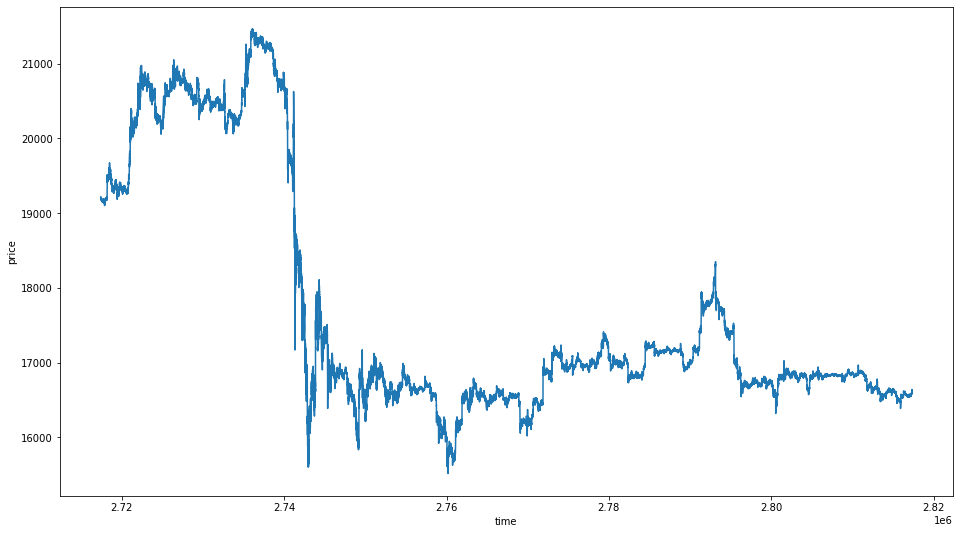

In [97]:
plt.figure(figsize=(16, 9))
sns.lineplot(y=df['Close'], x=df.index)
plt.xlabel('time')
plt.ylabel('price')

In [98]:
scaler = MinMaxScaler()
# 스케일을 적용할 column을 정의합니다.
scale_cols = ['Open', 'High', 'Low', 'Close', 'Volume', 'quote_av',
       'trades', 'tb_base_av', 'tb_quote_av', 'Return',
       'Maximum Hour Return', 'Price Volatility', 'Return Volatility',
       'Momentum 1H', 'Momentum 3H', 'Momentum 4H', 'Momentum 12H',
       'Momentum 24H', 'Maximum Daily Return', 'Avg Price']
# 스케일 후 columns
scaled = scaler.fit_transform(df[scale_cols])

df = pd.DataFrame(scaled, columns=scale_cols)

In [139]:
# 모델 생성 함수

def create_model(input_shape):
    model = Sequential([
        Conv1D(filters=64, kernel_size=8, padding="causal", activation="relu", input_shape=input_shape),
        LSTM(16, activation='tanh'),
        Dense(16, activation="relu"),
        Dense(1)
    ])
    loss = Huber()
    optimizer = Adam(0.00005)
    model.compile(loss=Huber(), optimizer=optimizer, metrics=['mse'])
    return model


In [140]:
def windowed_dataset(x, y, window_size, batch_size, shuffle):
    ds_x = tf.data.Dataset.from_tensor_slices(x)
    ds_x = ds_x.window(window_size, shift=1, stride=1, drop_remainder=True)
    ds_x = ds_x.flat_map(lambda x: x.batch(window_size))
    ds_y = tf.data.Dataset.from_tensor_slices(y[window_size:])
    ds = tf.data.Dataset.zip((ds_x, ds_y))
    if shuffle:
        ds = ds.shuffle(1000)
    return ds.batch(batch_size).prefetch(1)

In [141]:
# Parameters
WINDOW_SIZE = 5
BATCH_SIZE = 32


In [142]:
# Split the data
x_train, x_test, y_train, y_test = train_test_split(df, df['Close'], test_size=0.1, random_state=0, shuffle=False)


In [134]:
from sklearn.metrics import mean_squared_error

In [143]:
predicted = []

for i in range(1, 11):
    train_data = windowed_dataset(x_train, y_train, WINDOW_SIZE + i - 1, BATCH_SIZE, True)
    model = create_model([WINDOW_SIZE + i - 1, df.shape[1]])
    earlystopping = EarlyStopping(monitor='loss', patience=35)
    filename = os.path.join('tmp', f'ckeckpointer_step_{i}.ckpt')
    checkpoint = ModelCheckpoint(filename, 
                                 save_weights_only=True, 
                                 save_best_only=True, 
                                 monitor='loss', 
                                 verbose=1)
    history = model.fit(train_data, epochs=50, callbacks=[checkpoint, earlystopping])

    model.load_weights(filename)
    window = x_train[-(WINDOW_SIZE + i - 1):].values.reshape(1, WINDOW_SIZE + i - 1, -1)
    pred = model.predict(window)
    predicted.append(pred[0, 0])
        


Epoch 1/50
   2812/Unknown - 12s 4ms/step - loss: 0.0063 - mse: 0.0125
Epoch 1: loss improved from inf to 0.00627, saving model to tmp\ckeckpointer_step_1.ckpt
2813/2813 [==============================] - 12s 4ms/step - loss: 0.0063 - mse: 0.0125
Epoch 2/50
2811/2813 [============================>.] - ETA: 0s - loss: 3.8744e-05 - mse: 7.7488e-05
Epoch 2: loss improved from 0.00627 to 0.00004, saving model to tmp\ckeckpointer_step_1.ckpt
2813/2813 [==============================] - 10s 4ms/step - loss: 3.8726e-05 - mse: 7.7451e-05
Epoch 3/50
2812/2813 [============================>.] - ETA: 0s - loss: 1.2074e-05 - mse: 2.4148e-05
Epoch 3: loss improved from 0.00004 to 0.00001, saving model to tmp\ckeckpointer_step_1.ckpt
2813/2813 [==============================] - 10s 3ms/step - loss: 1.2073e-05 - mse: 2.4145e-05
Epoch 4/50
2807/2813 [============================>.] - ETA: 0s - loss: 8.2959e-06 - mse: 1.6592e-05
Epoch 4: loss improved from 0.00001 to 0.00001, saving model to tmp\ckeckp

KeyboardInterrupt: 

In [136]:
print(f"Predicted values: {predicted}")
print(f"Actual values: {y_test[:10].values}")
print(f"MSE: {mean_squared_error(y_test[:10].values, predicted)}")

Predicted values: [0.22122201, 0.22142531, 0.22139914, 0.2211343, 0.22140218, 0.22153713, 0.22129655, 0.22202323, 0.22125873, 0.22133063]
Actual values: [0.2215403  0.22188294 0.22176705 0.22196692 0.22181408 0.22204418
 0.22204418 0.22152183 0.22140257 0.22159405]
MSE: 2.4665510328195634e-07


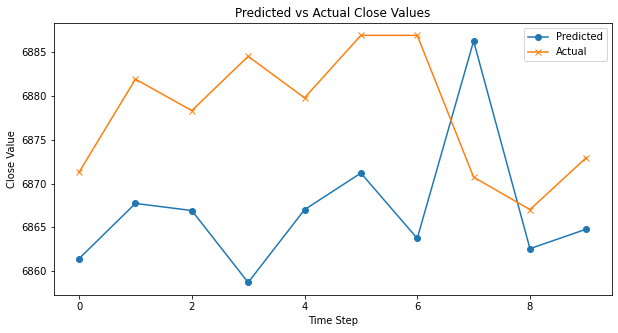

In [138]:
import matplotlib.pyplot as plt

# predicted와 y_test[:5]를 31016으로 곱함
predicted_scaled = [p * 31016 for p in predicted[:10]]
actual_scaled = [a * 31016 for a in y_test[:10].values]

# 그래프를 그림
plt.figure(figsize=(10, 5))
plt.plot(predicted_scaled, label="Predicted", marker='o')
plt.plot(actual_scaled, label="Actual", marker='x')
plt.xlabel('Time Step')
plt.ylabel('Close Value')
plt.legend()
plt.title('Predicted vs Actual Close Values')
plt.show()